In [ ]:
# Import ncessary libraries
import nltk
import nltk.downloader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib
from termcolor import colored

# Download necessary NLTK data
nltk.download('punkt')       # Tokenizer
nltk.download('stopwords')   # Stopword corpus
nltk.download('wordnet')     # WordNet corpus for lemmatization

#nltk.download('all')



[nltk_data] Downloading package punkt to /home/jparep/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jparep/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jparep/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/jparep/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/jparep/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/jparep/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]   

True

In [2]:
# Configuration settings
FAKE_CSV_PATH = '/home/jparep/proj/nlp-tweet-analysis/data/raw/fake.csv'
REAL_CSV_PATH = '/home/jparep/proj/nlp-tweet-analysis/data/raw/true.csv'
MODEL_PATH = '/home/jparep/proj/nlp-tweet-analysis/model/model.pkl'
VECTORIZER_PATH = '/home/jparep/proj/nlp-tweet-analysis/model/vectorizer.pkl'
RANDOM_SEED = 42

# Initliaze stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Set random seed for reproducibility
np.random.seed(RANDOM_SEED)

In [3]:
def read_csv_files(real_csv, fake_csv):
    """Load data and label fake and real and return concatenate dataframe"""
    df_fake = pd.read_csv(fake_csv)
    df_real = pd.read_csv(real_csv)
    
    df_fake['label'] = 'fake'
    df_real['label'] = 'real'
    
    df_concat = pd.concat([df_fake, df_real], axis=0).sample(frac=1).reset_index(drop=True)
    return df_concat

In [4]:
def preprocess_text(text):
    """Preprocess data"""
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text).lower()
    tokens = word_tokenize(text)
    lem = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(lem)

In [5]:
def load_and_preprocess_data():
    """Load data and preprocess. Make fake and real to 1 and 0 respectively"""
    df = read_csv_files(REAL_CSV_PATH, FAKE_CSV_PATH)
    df = df[['text', 'label']]
    df['processed_text'] = df['text'].apply(preprocess_text)
    df["label"] = df["label"].map({"real": 0, "fake": 1})
    return df

In [6]:
# Analyse preprocessed data
df = load_and_preprocess_data()
df.head(5)

,text,label,processed_text
0,"21st Century Wire says Ben Stein, reputable pr...",1,21st century wire say ben stein reputable prof...
1,WASHINGTON (Reuters) - U.S. President Donald T...,0,washington reuters u president donald trump re...
2,(Reuters) - Puerto Rico Governor Ricardo Rosse...,0,reuters puerto rico governor ricardo rossello ...
3,"On Monday, Donald Trump once again embarrassed...",1,monday donald trump embarrassed country accide...
4,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",0,glasgow scotland reuters u presidential candid...


In [ ]:
# Train-validate-test split
def train_valid_test_split(X, y, train_size=0.7, valid_size=0.15, test_size=0.15):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(valid_size + test_size), random_state=RANDOM_SEED)
    
    ratio = valid_size / (valid_size + test_size)
    
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=(1.0 - ratio), random_state=RANDOM_SEED)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [8]:
# call method
X = df['processed_text']
y = df['label']
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y)

In [9]:
# Vectorize data
def vectorize_data(X_train, X_valid, X_test):
    vectorizer = TfidfVectorizer()
    xv_train = vectorizer.fit_transform(X_train)
    xv_valid = vectorizer.fit_transform(X_valid)
    xv_test = vectorizer.fit_transform(X_test)
    
    with open(VECTORIZER_PATH, 'wb') as f:
        joblib.dump(vectorizer, f)
    
    return xv_train, xv_valid, xv_test, vectorizer

# call method
xv_train, xv_valid, xv_test, vectorizer = vectorize_data(X_train, X_valid, X_test)

In [10]:
# Train Model
def train_model(X_train, y_train, model):
    model.fit(X_train, y_train)
    return model

In [11]:
# Save Model
def save_model(model, model_path):
    with open(model_path, 'wb') as f:
        joblib.dump(model, f)

In [15]:
# models dict
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_SEED),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_SEED),
    'Passive Agressive': PassiveAggressiveClassifier(random_state=RANDOM_SEED),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_SEED)
}

for name, model in models.items():
    print(f"Training {name}...")
    model_trained = train_model(xv_train, y_train, model)
    save_model(model_trained, f"/home/jparep/proj/nlp-tweet-analysis/model/{name.replace(' ', '_').lower()}.pkl")

Training Logistic Regression...
Training MultinomialNB...
Training RandomForest...
Training Passive Agressive...
Training Decision Tree...


In [16]:
# Evaluate Models
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"ROC AUC Score: {roc_auc}")
    print(classification_report(y_true, y_pred, target_names=["Real", "Fake"]))

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
    disp.plot()
    plt.show()

for name, model in models.items():
    print(f"Evaluating {name}...")
    with open(f"/home/jparep/proj/nlp-tweet-analysis/model/{name.replace(' ', '_').lower()}.pkl", 'rb') as f:
        trained_model = joblib.load(f)
    
    y_train_pred = trained_model.predict(xv_train)
    y_valid_pred = trained_model.predict(xv_valid)
    y_test_pred = trained_model.predict(xv_test)

    evaluate_model(y_train, y_train_pred, f"{name} (train)")
    evaluate_model(y_valid, y_valid_pred, f"{name} (valid)")
    evaluate_model(y_test, y_test_pred, f"{name} (test)")
    plot_confusion_matrix(y_test, y_test_pred)


Evaluating Logistic Regression...


ValueError: X has 48372 features, but LogisticRegression is expecting 97406 features as input.

In [13]:
# Hyperparameter Tuning
def hyperparameter_tuning(X_train, y_train):
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=10000)),
        ('classifier', DecisionTreeClassifier(random_state=RANDOM_SEED))
    ])

    param_distributions = {
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 7, 9]
    }

    search = RandomizedSearchCV(pipeline, param_distributions, n_iter=12, cv=10, n_jobs=-1, random_state=RANDOM_SEED, verbose=1)
    search.fit(X_train, y_train)
    return search.best_estimator_

optimized_model = hyperparameter_tuning(X_train, y_train)
with open(MODEL_PATH, 'wb') as f:
    joblib.dump(optimized_model, f)

print(f"Optimized model saved to {MODEL_PATH}")


Fitting 10 folds for each of 12 candidates, totalling 120 fits


/home/jparep/anaconda3/envs/nlp-env/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Optimized model saved to /home/jparep/proj/nlp-tweet-analysis/model/model.pkl


Model: Optimized DecisionTree (train)
Accuracy: 0.9980590556191931
F1 Score: 0.9980591341269179
Precision: 0.9990236162811985
Recall: 0.9972587719298246
ROC AUC Score: 0.998096478957185
              precision    recall  f1-score   support

        Real       1.00      1.00      1.00     15012
        Fake       1.00      1.00      1.00     16416

    accuracy                           1.00     31428
   macro avg       1.00      1.00      1.00     31428
weighted avg       1.00      1.00      1.00     31428

Model: Optimized DecisionTree (valid)
Accuracy: 0.9948032665181886
F1 Score: 0.9948035681642924
Precision: 0.9962952408093474
Recall: 0.9937464468447982
ROC AUC Score: 0.9948527074136952
              precision    recall  f1-score   support

        Real       0.99      1.00      0.99      3217
        Fake       1.00      0.99      1.00      3518

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99     

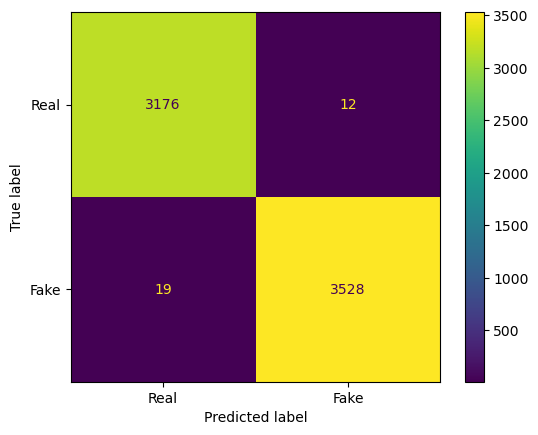

In [17]:
# Evaluate Optimized Model
with open(MODEL_PATH, 'rb') as f:
    optimized_model = joblib.load(f)

y_train_pred = optimized_model.predict(X_train)
y_valid_pred = optimized_model.predict(X_valid)
y_test_pred = optimized_model.predict(X_test)

evaluate_model(y_train, y_train_pred, "Optimized DecisionTree (train)")
evaluate_model(y_valid, y_valid_pred, "Optimized DecisionTree (valid)")
evaluate_model(y_test, y_test_pred, "Optimized DecisionTree (test)")
plot_confusion_matrix(y_test, y_test_pred)


In [18]:
# Save the optimized model and vectorizer
with open(MODEL_PATH, 'wb') as f:
    joblib.dump(optimized_model, f)

with open(VECTORIZER_PATH, 'wb') as f:
    joblib.dump(vectorizer, f)
